In [1]:
import sys
sys.path.append('../src/')

import torch
import os
import wandb
import numpy as np

#from models.u_net import UNet
from model_zoo.unet import UNet
from data.dataset import SegmentationDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary
import torchvision.transforms as transforms
from transforms.tensor_transforms import Create2D, Rescale, AddChannel, NormalizeSample
from utils.utils import inspect_single_data_pair
from utils.eval_metrics import DiceLoss
import torch.optim
from transforms.transforms_handler import *
from transforms.image_transforms import RandomVerticalFlip

/home/moritz/anaconda3/envs/Registration/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# constants
DATASET_PATH = '../data/raw/EMPIRE10/scans/'
DATA_OUT_s = '/home/moritz/Thesis/ImageRegistration/data/interim/EMPIRE10/scans/'
DATA_OUT_m = '/home/moritz/Thesis/ImageRegistration/data/interim/EMPIRE10/masks/'

In [3]:
filename = list(set([x.split('_')[0]
                     for x in os.listdir(DATASET_PATH)]))
partition = {}
partition['train'], partition['validation'] = train_test_split(
    filename, test_size=0.33, random_state=42)

shape=(256, 256)
pre_transform = transforms.Compose([
    # Data Preprocessing
    Create2D('y'),
    AddChannel(axs=0),
    Rescale(shape)
])


In [4]:
transform = ComposeDouble([
    FunctionWrapperDouble(RandomVerticalFlip(prob=1)),
])

Cache and preprocess data in a multiprocessing context...
Done!
x = shape: torch.Size([1, 1, 256, 256]); type: torch.float32
x = min: 0.05882352963089943; max: 0.9529411792755127
y = shape: torch.Size([1, 1, 256, 256]); type: torch.float32
y = min: 0.0; max: 1.0


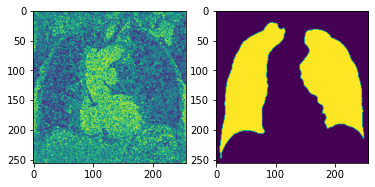

In [5]:
inspect_single_data_pair('SegmentationDataset', partition['train'], dataset='EMPIRE10', transform=transform, pre_transform=pre_transform)

In [6]:
# Generators
training_set = SegmentationDataset(partition['train'], dataset='EMPIRE10', transform=transforms, use_cache=True, pre_transform=pre_transform)
print(training_set)
batch_size=1
training_loader = DataLoader(training_set, batch_size=batch_size,
		                                shuffle=True, pin_memory=True)

Cache and preprocess data in a multiprocessing context...


TypeError: can't pickle module objects

In [ ]:
# inspect model before training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

#model = UNet().to(device)
model = UNet()
#summary(model, (1, 256, 256))

In [ ]:
x = next(iter(training_loader))

In [ ]:
x[0].shape

In [ ]:
rand = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32)
#print()
with torch.no_grad():
    out = model(x[0])
print(out[0].shape)

In [ ]:
axis = [np.random.binomial(1, 1, 1000)]
print(axis)

In [ ]:
from utils.utils import LearningRateFinder
optimizer = torch.optim.Adam(model.parameters())
criterion = DiceLoss()

In [ ]:
lrf = LearningRateFinder(model, criterion, optimizer, device="cuda")
lrf.fit(training_loader, steps=1000)

In [ ]:
lrf.plot()